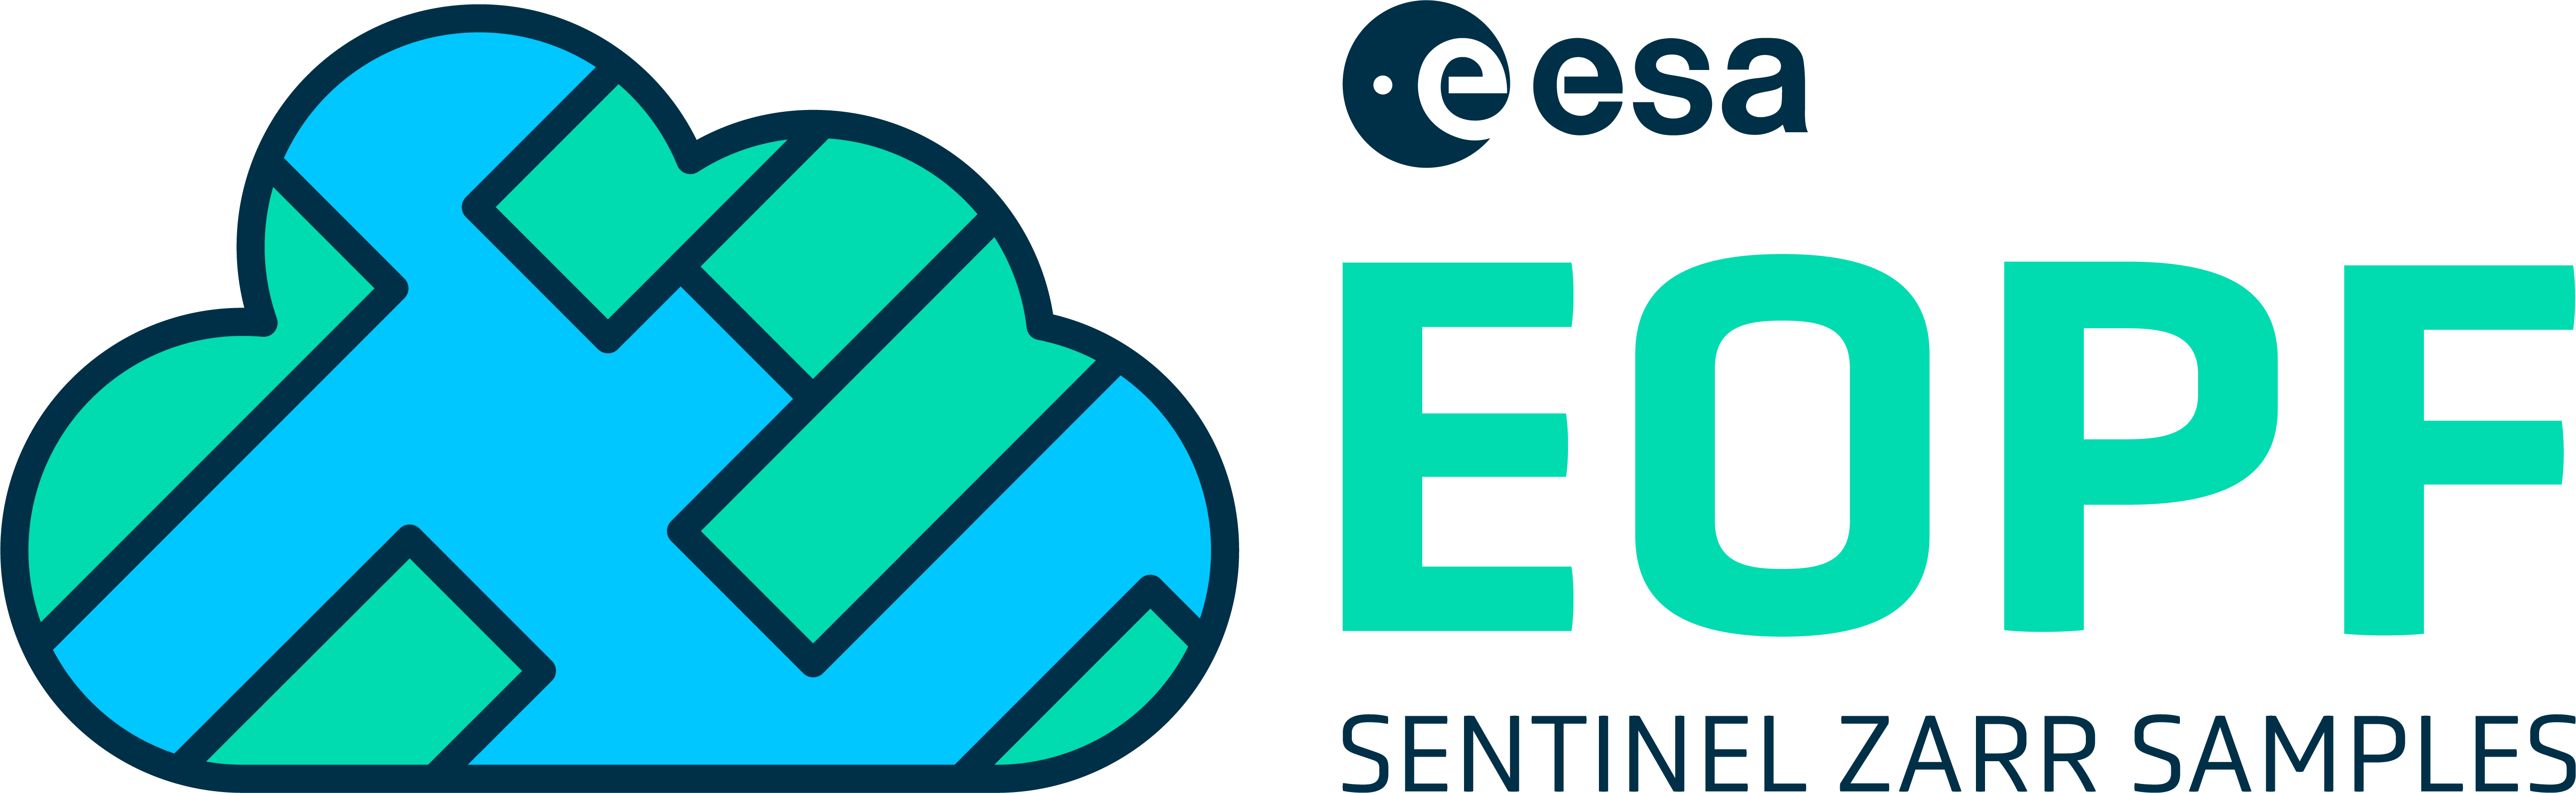

## Sentinel-2 L1C MSI Product Format Prototype

## Table of Contents
1. [Introduction](#Introduction)  
2. [Import modules](#Import-modules)  
3. [Open the product](#Open-the-product)  
4. [Overview of the product content](#Overview-of-the-product-content)  
5. [Plot a RGB image](#Plot-a-RGB-image)  
6. [Explore product geolocation](#Explore-product-geolocation)  
   A. [Interactive map](#Interactive-map)  
   B. [Non-interactive map](#Non-interactive-map)  
   C. [Plot georeferenced data](#Plot-georeferenced-data)
7. [Compute radiances](#Compute-radiances)
8. [Visualise](#Visualise)


## Introduction

In this notebook we will show an example of using Sentinel-2 L1C MSI Prodct and some easy usage examples


## Import modules

Dependencies

- datatree
- eopf
- xarray
- matplotlib
- cartopy
- numpy
- fsspec
- geopandas

In [1]:
import datatree
from eopf.product.eo_variable import EOVariable
import cartopy.crs as ccrs  # For static plotting
import cartopy.feature as cf
import geopandas  # For interactive plotting
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import xarray as xr
import fsspec

## Open the product


In [2]:
# Define the remote product path
remote_product_path = "https://eopf-public.s3.sbg.perf.cloud.ovh.net/eoproducts/S2MSIL1C_20231001T094031_N0509_R036_T33RUJ_T345.zarr.zip"

# Construct the fsspec mapper path
store = fsspec.get_mapper(f"zip::{remote_product_path}")

# Load it with datatree
dt = datatree.open_datatree(store, engine="zarr", consolidated=False, chunks={})

## Overview of the product content

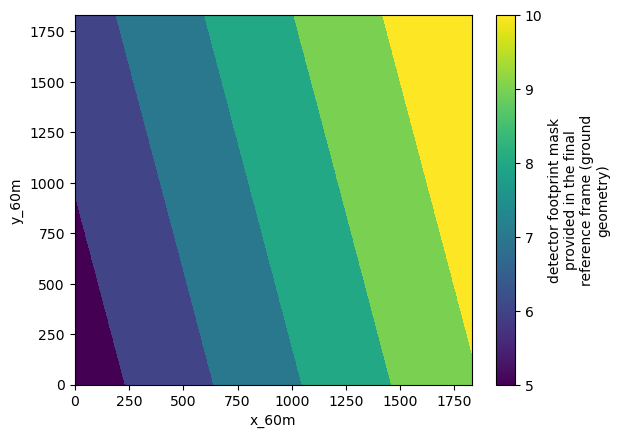

In [3]:
dt["conditions/msk_detfoo_b01"].plot()

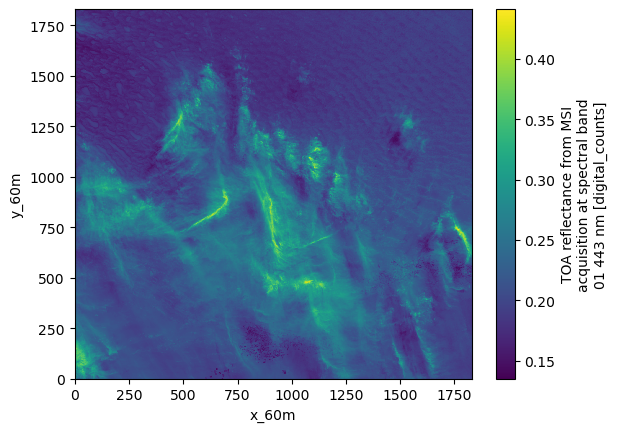

In [4]:
dt["measurements/reflectances_60m"]["b01_60m"].plot()

In [5]:
dt["measurements/reflectances_60m"]["b01_60m"].encoding["add_offset"]

-0.1

In [6]:
min, max, mean = (
    dt["measurements/reflectances_60m"]["b01_60m"].data.max(),
    dt["measurements/reflectances_60m"]["b01_60m"].data.min(),
    dt["measurements/reflectances_60m"]["b01_60m"].data.mean(),
)
min.compute(), max.compute(), mean.compute()

(0.44120000000000004, 0.1349, 0.21381266403893812)

In [7]:
r = dt["measurements/reflectances_10m"]["b04_10m"]
g = dt["measurements/reflectances_10m"]["b03_10m"]
b = dt["measurements/reflectances_10m"]["b02_10m"]

xr.Dataset(dict(r=r, g=g, b=b))
# Check indexes

<xarray.Dataset> Size: 3GB
Dimensions:  (y_10m: 10980, x_10m: 10980)
Dimensions without coordinates: y_10m, x_10m
Data variables:
    r        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    g        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

In [8]:
b02 = dt["measurements/reflectances_10m"]["b02_10m"]
b02

<xarray.DataArray 'b02_10m' (y_10m: 10980, x_10m: 10980)> Size: 964MB
dask.array<open_dataset-b02_10m, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Dimensions without coordinates: y_10m, x_10m
Attributes:
    dimensions:  y_10m x_10m
    dtype:       <u2
    long_name:   TOA reflectance from MSI acquisition at spectral band 02 490 nm
    short_name:  b02_10m
    units:       digital_counts
    valid_max:   65535
    valid_min:   1

In [9]:
b02.dtype

dtype('float64')

In [10]:
b02.encoding

{'chunks': (1830, 1830),
 'preferred_chunks': {'y_10m': 1830, 'x_10m': 1830},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 0,
 'scale_factor': 0.0001,
 'add_offset': -0.1,
 'dtype': dtype('uint16'),
 'coordinates': 'y_10m x_10m'}

## Plot a RGB image


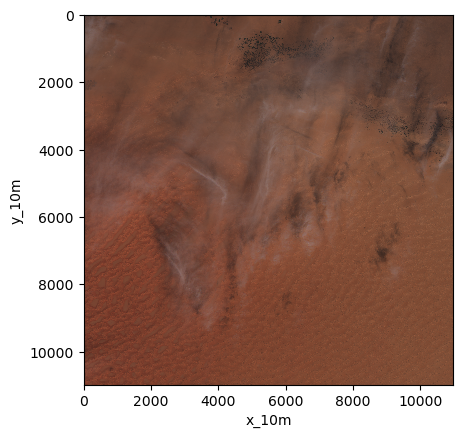

In [11]:
rgb_band_paths = (
    "measurements/reflectances_10m/b04_10m",
    "measurements/reflectances_10m/b03_10m",
    "measurements/reflectances_10m/b02_10m",
)

concat = xr.concat(
    [dt[str(p)] for p in rgb_band_paths],  # type: ignore
    dim="band",
)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

## Explore product geolocation

The following snippet shows an interactive map with the tile's footprint
### Interactive map



In [12]:
gdf = geopandas.GeoDataFrame.from_features(
    [
        {
            "type": "Feature",
            "geometry": dt.attrs["geometry"],
            "properties": dt.attrs["properties"],
        }
    ]
)

Note: CRS is missing from the metadata, it must be set manually



In [13]:
gdf = gdf.set_crs(4326)

In [14]:
gdf.explore()

In [15]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Non-interactive map

The following snippet shows the location of the tile on a global map.




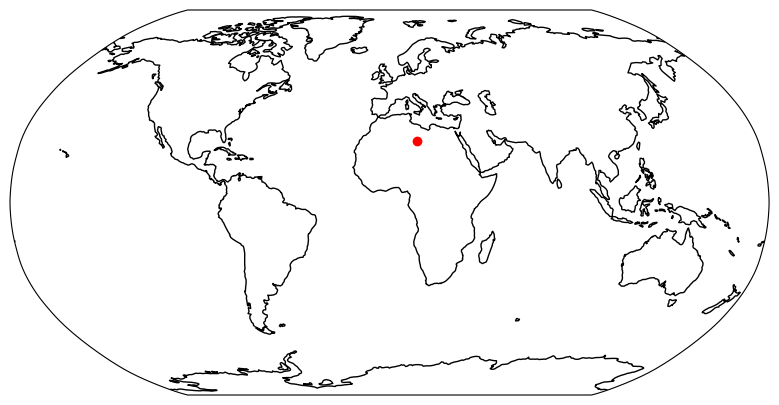

In [16]:
def main():
    # Assume gdf is already defined somewhere before this function
    # Reproject to a projected CRS
    gdf_projected = gdf.to_crs(epsg=3857)  # Change to an appropriate projected CRS
    centroids = gdf_projected.centroid

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # Make the map global rather than have it zoom in to the extents of any plotted data
    ax.set_global()

    # ax.stock_img()
    ax.coastlines()

    # Transform back to geographic CRS for plotting
    gdf_centroids_geographic = centroids.to_crs(epsg=4326)

    ax.plot(
        gdf_centroids_geographic.x,
        gdf_centroids_geographic.y,
        "ro",
        transform=ccrs.PlateCarree(),
    )

    plt.show()


if __name__ == "__main__":
    main()

### Plot georeferenced data


In [17]:
# Define constant for plotting
L1C_PROJECTION = ccrs.epsg(32633)
DESIRED_PROJECTION = ccrs.PlateCarree()
FIGSIZE: tuple[int, int] = (12, 8)
RESOLUTION_CARTOPY: str = "110m"
# GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (-20, 30, 10, 30)
GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (10, 20, 24, 28)

# Speed up plot by sampling data every SKIP_EVERY pixels
SKIP_EVERY: int = 50

# Define plotting arguments for Polygon around the area of interest
POLYGON_THICKNESS: int = 1
POLYGON_COLOR: str = "r"

# Get the geometry from the product and check that it correspond to the domain represented
geometry_from_product = np.squeeze(dt.attrs["geometry"]["coordinates"])
geometry_from_product

array([[12.99829791, 26.20599492],
       [14.09705684, 26.21709405],
       [14.10451217, 25.22570007],
       [13.01481479, 25.2150795 ],
       [12.99829791, 26.20599492]])

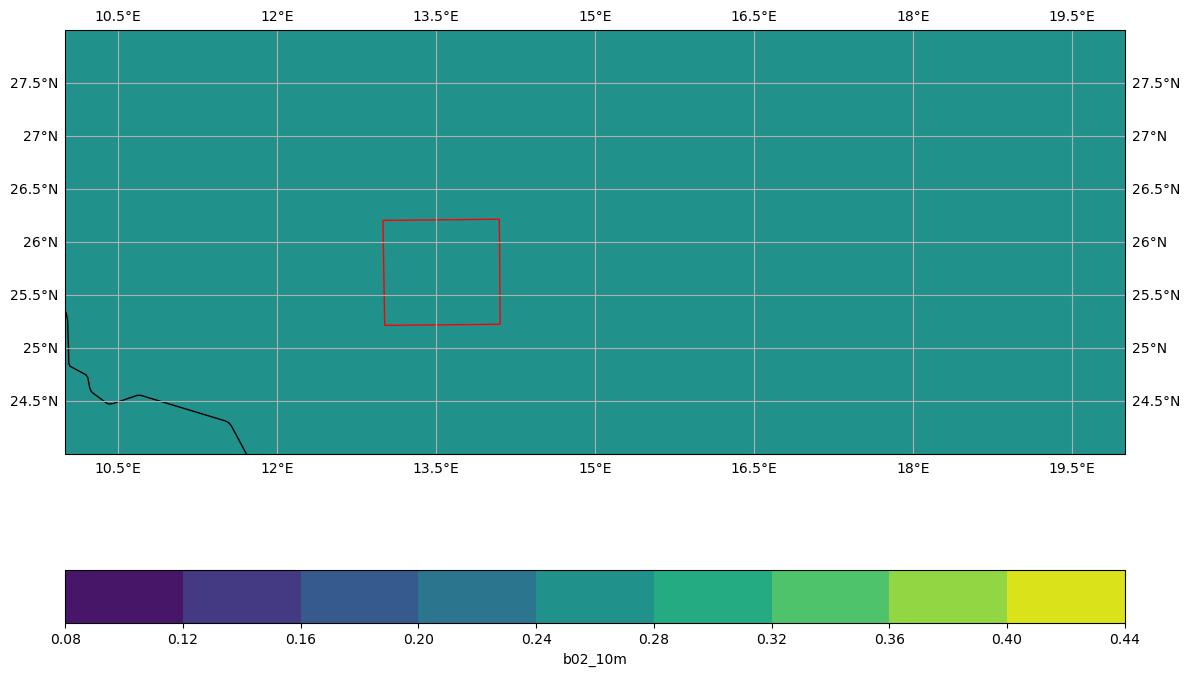

In [18]:
_, ax = plt.subplots(subplot_kw={"projection": DESIRED_PROJECTION}, figsize=FIGSIZE)

# Plot cartopy geographic information
ax.coastlines(resolution=RESOLUTION_CARTOPY)
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
gl = ax.gridlines(draw_labels=True, crs=DESIRED_PROJECTION)


b02 = dt["measurements/reflectances_10m"]["b02_10m"]
plt.contourf(b02[::SKIP_EVERY, ::SKIP_EVERY], transform=L1C_PROJECTION)
poly = mpatches.Polygon(
    geometry_from_product,
    closed=True,
    ec=POLYGON_COLOR,
    fill=False,
    lw=POLYGON_THICKNESS,
    transform=DESIRED_PROJECTION,
)
ax.add_patch(poly)
ax.set_extent(GEOGRAPHICAL_LIMITS, crs=DESIRED_PROJECTION)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label("b02_10m")
plt.tight_layout()

## Compute radiances

From: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c

$\text{radiance} = \text{reflectance} \times \cos\left(\text{radians}(\text{SunZenithAngle})\right) \times \text{solarIrradiance} \times \frac{U}{\pi}$
$
\]


In [19]:
U: float = dt.attrs["other_metadata"][
    "reflectance_correction_factor_from_the_Sun-Earth_distance_variation_computed_using_the_acquisition_date"
]
U

0.995947582346581

In [20]:
# Be carefull, Sun Zenith Angle is expressed on the angles grid (5km), it needs to be reprojected on the 10m grid for computing radiances
# cosinus is applied now because we can not interpolate angles using a linear interpolation (discontinuity at 0°)
# On the other hand, cosines can be interpolated
# cos_zsa_5km: EOVariable = np.cos(np.deg2rad(xdt[].conditions.geometry.sza))
# cos_zsa_5km

cos_sza_5km: EOVariable = np.cos(np.deg2rad(dt["conditions/geometry/sza"]))
cos_sza_5km

<xarray.DataArray 'sza' (y_a: 23, x_a: 23)> Size: 4kB
dask.array<cos, shape=(23, 23), dtype=float64, chunksize=(23, 23), chunktype=numpy.ndarray>
Dimensions without coordinates: y_a, x_a
Attributes:
    dimensions:  y_a x_a
    dtype:       <f4
    long_name:   sun zenith angle
    short_name:  sza
    units:       degrees

In [21]:
# We will convert reflectances from band BAND to radiances
BAND: int = 2

# Band - 1 because Python list index starts at 0
solarIrradiance: float = np.float64(
    dt.attrs["properties"]["eo:bands"][BAND - 1]["solar_illumination"]
)

In [22]:
reflectance_b02_10m: EOVariable = dt["measurements/reflectances_10m/b02_10m"]
reflectance_b02_10m

<xarray.DataArray 'b02_10m' (y_10m: 10980, x_10m: 10980)> Size: 964MB
dask.array<open_dataset-b02_10m, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Dimensions without coordinates: y_10m, x_10m
Attributes:
    dimensions:  y_10m x_10m
    dtype:       <u2
    long_name:   TOA reflectance from MSI acquisition at spectral band 02 490 nm
    short_name:  b02_10m
    units:       digital_counts
    valid_max:   65535
    valid_min:   1

In [23]:
# Interpolate sza on the angles grid to the 10m grid
cos_sza_10m: xr.DataArray = cos_sza_5km.interp_like(reflectance_b02_10m)
cos_sza_10m.compute()

<xarray.DataArray 'sza' (y_a: 23, x_a: 23)> Size: 4kB
array([[0.83651001, 0.83671748, 0.83692483, 0.83713111, 0.83733726,
        0.8375433 , 0.83774826, 0.83795311, 0.83815784, 0.8383615 ,
        0.83856504, 0.83876751, 0.83896987, 0.83917212, 0.83937329,
        0.83957341, 0.83977436, 0.83997424, 0.84017307, 0.84037178,
        0.84057039, 0.84076887, 0.84096536],
       [0.83689808, 0.83710628, 0.83731341, 0.83752041, 0.83772634,
        0.83793215, 0.83813785, 0.83834247, 0.83854602, 0.83875041,
        0.83895373, 0.83915598, 0.83935811, 0.83956013, 0.83976109,
        0.83996193, 0.84016266, 0.84036232, 0.84056188, 0.84076037,
        0.84095875, 0.84115702, 0.84135423],
       [0.83728669, 0.83749466, 0.83770156, 0.83790834, 0.838115  ,
        0.83832058, 0.8385251 , 0.83873045, 0.83893473, 0.83913794,
        0.83934104, 0.83954401, 0.83974688, 0.83994773, 0.84014941,
        0.84035003, 0.84055053, 0.84074997, 0.8409493 , 0.84114852,
        0.84134668, 0.84154472, 0.84174171],
       [0.83767487, 0.83788262, 0.83808929, 0.83829584, 0.83850228,
        0.83870764, 0.83891288, 0.83911801, 0.83932206, 0.839526  ,
        0.83972887, 0.83993162, 0.84013426, 0.84033584, 0.84053729,
        0.84073769, 0.84093797, 0.84113719, 0.84133725, 0.8415353 ,
        0.84173418, 0.84193106, 0.84212877],
...
       [0.84381037, 0.8440173 , 0.8442241 , 0.84443078, 0.8446364 ,
        0.84484096, 0.8450454 , 0.84524971, 0.8454539 , 0.84565703,
        0.84585911, 0.846062  , 0.84626291, 0.84646463, 0.8466653 ,
        0.84686491, 0.84706534, 0.84726379, 0.84746305, 0.84766127,
        0.84785844, 0.8480555 , 0.84825243],
       [0.84418949, 0.84439619, 0.84460276, 0.84480921, 0.8450146 ,
        0.84521986, 0.845425  , 0.84562909, 0.84583211, 0.84603595,
        0.84623781, 0.84644047, 0.84664208, 0.84684264, 0.84704401,
        0.84724432, 0.8474436 , 0.84764275, 0.84784086, 0.84803977,
        0.84823672, 0.84843447, 0.84863118],
       [0.84456819, 0.84477559, 0.84498193, 0.84518815, 0.84539331,
        0.84559834, 0.84580325, 0.84600711, 0.84621084, 0.84641351,
        0.84661607, 0.8468185 , 0.84701988, 0.84722115, 0.84742228,
        0.84762238, 0.84782142, 0.84802035, 0.84821916, 0.84841692,
        0.84861456, 0.84881209, 0.84900858],
       [0.84494646, 0.8451527 , 0.84535974, 0.84556573, 0.84577159,
        0.8459764 , 0.84618108, 0.8463847 , 0.8465882 , 0.84679158,
        0.84699391, 0.84719611, 0.84739819, 0.84759922, 0.84779921,
        0.84799907, 0.84819882, 0.84839844, 0.84859702, 0.84879456,
        0.84899198, 0.84918928, 0.84938554]])
Dimensions without coordinates: y_a, x_a
Attributes:
    dimensions:  y_a x_a
    dtype:       <f4
    long_name:   sun zenith angle
    short_name:  sza
    units:       degrees

In [24]:
# For simplicity, radiance computation assume that reflectances equal numerical counts

radiance = reflectance_b02_10m * cos_sza_10m * solarIrradiance * U / np.pi
radiance

<xarray.DataArray (y_10m: 10980, x_10m: 10980, y_a: 23, x_a: 23)> Size: 510GB
dask.array<truediv, shape=(10980, 10980, 23, 23), dtype=float64, chunksize=(1830, 1830, 23, 23), chunktype=numpy.ndarray>
Dimensions without coordinates: y_10m, x_10m, y_a, x_a

## Visualise

Visualize computational graph (Needs to have graphviz package)


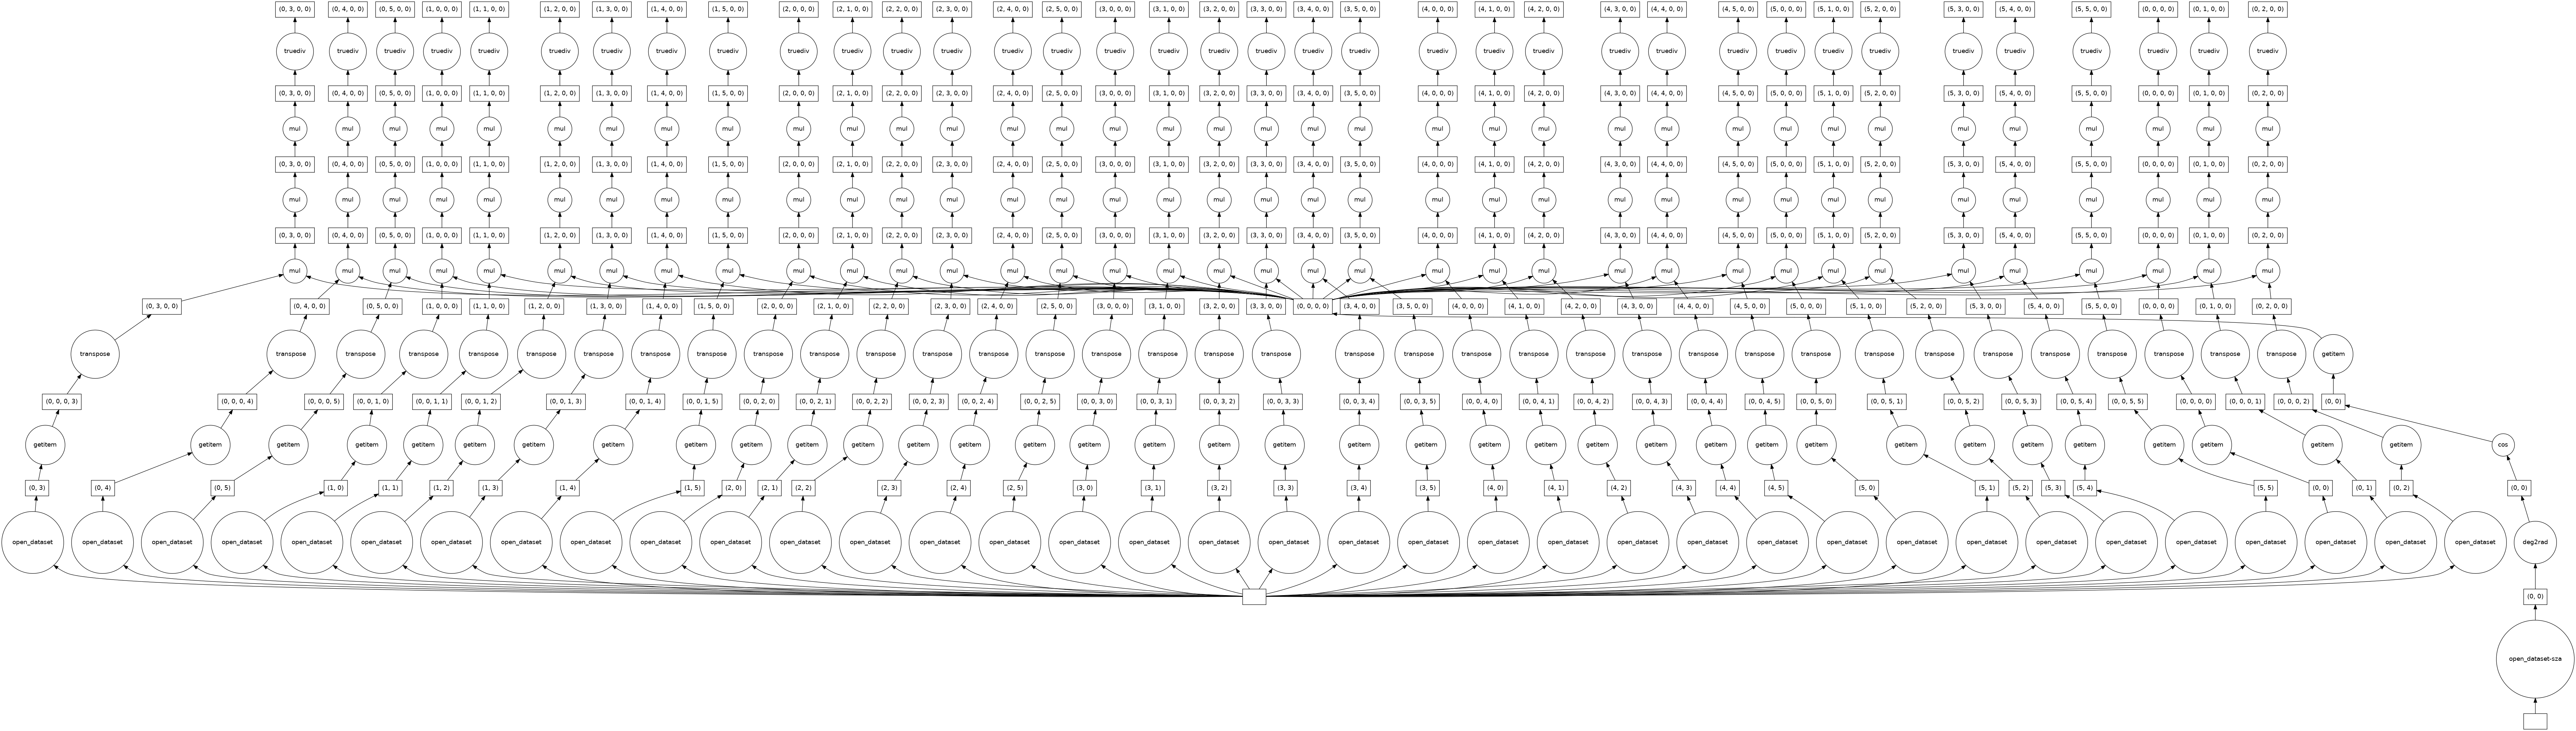

In [25]:
radiance.data.visualize()

In [26]:
# radiance.plot()

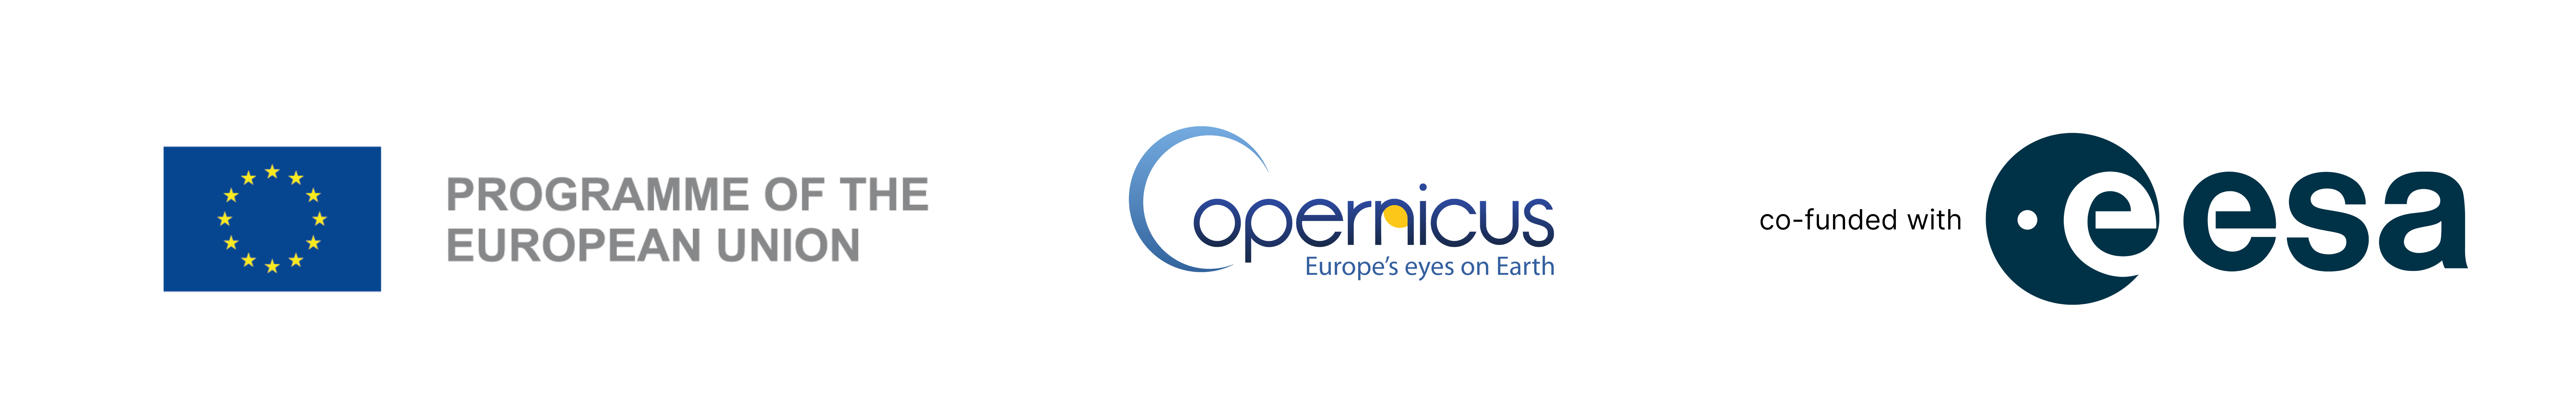